In [196]:
from astropy.coordinates import Angle, SkyCoord, EarthLocation, AltAz, get_body, ICRS
import astropy.constants as c
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
import astropy.units as u
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import WCSAxes

from astroquery.hips2fits import hips2fits
hips2fits.timeout = 300 # Necessary to prevent timeouts for downloading large files

from matplotlib import patheffects
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import os

from regions import Regions, PolygonSkyRegion

%matplotlib widget

hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
global hatch_idx
hatch_idx = 0

In [197]:
def wrap360(ang):
    return ((ang + 360.) % 360.)

In [198]:
EL_MIN = 20
EL_MAX = 52
DAZ_MIN = 90
DAZ_MAX = 225
az_limleft = lambda x: wrap360(x - 270)
az_limright = lambda x: wrap360(x - 135)


mcmurdo = EarthLocation(lat='-77.8419', lon='166.6863', height=37000.)
# mcmurdo = EarthLocation(lat='-77.8419', lon='346.6863', height=37000.) # halfway around continent
launch_date = Time('2026-12-25 00:00:00', scale='utc', location=mcmurdo)

step_hr = 1
oneday = np.arange(0, 24 + step_hr, step_hr) * u.hr
oneweek = np.arange(0, 24 * 7 + step_hr, step_hr) * u.hr
threeweeks = np.arange(0, (24 * 7 * 3) + step_hr, step_hr) * u.hr

times = launch_date + oneday
t = (times - times[0]).to(u.hr)

sun_body = get_body('sun', times, location=mcmurdo)
sun = SkyCoord(ra=sun_body.ra, dec=sun_body.dec, obstime=times, location=mcmurdo)
sun_altaz = sun.transform_to('altaz')

gal_center = SkyCoord(ra='17h45m40.04s', dec='-29d00m28.s', obstime=times[0], location=mcmurdo)

goods_s = SkyCoord(ra='3h32m36.51s', dec='-27d47m33.74s', obstime=times, location=mcmurdo)
goods_s_altaz = goods_s.transform_to('altaz')

edfs = SkyCoord(ra='04h04m57.84s', dec='-48d25m22.8s', obstime=times[0], location=mcmurdo)

edff = SkyCoord(ra='03h31m43.6s', dec='-28d05m18.6s', obstime=times[0], location=mcmurdo)

spt_summer = SkyCoord(ra='0h0m0s', dec='-57d30m0s', obstime=times[0], location=mcmurdo) # 500 deg^2
spt_winter = SkyCoord(ra='0h0m0s', dec='-66d0m0s', obstime=times[0], location=mcmurdo) # 1500 deg^2

In [199]:
def plot_from_catalog_helper_t_vs_el(ax, name, skycoord_override=None):
    global hatch_idx
    if not skycoord_override:
        foo = SkyCoord.from_name(name)
        coord = SkyCoord(foo.ra, foo.dec, obstime=times, location=mcmurdo)
    else:
        coord = skycoord_override
    foo_altaz = coord.transform_to(AltAz)
    l, = ax.plot(t, foo_altaz.alt.deg, marker='.', label=name)

    in_bounds = np.where((foo_altaz.alt.deg >= EL_MIN) & (foo_altaz.alt.deg <= EL_MAX))[0]
    for i0, i1 in zip(range(len(t))[:-1], range(len(t))[1:]):
        if (i0 in in_bounds) and (i1 in in_bounds):
            ax.axvspan(t[i0].value, t[i1].value, alpha=0.2, color=l.get_color(), hatch=hatches[hatch_idx])
    hatch_idx += 1
    return coord, foo_altaz


def plot_from_catalog_helper_t_vs_az(ax, name, skycoord_override=None):
    if not skycoord_override:
        foo = SkyCoord.from_name(name)
        coord = SkyCoord(foo.ra, foo.dec, obstime=times, location=mcmurdo)
    else:
        coord = skycoord_override
    foo_altaz = coord.transform_to(AltAz)
    l, = ax.plot(t, foo_altaz.az.deg, marker='.', label=name)

    return coord, foo_altaz


def plot_from_catalog_helper_t_vs_delta_sun(ax, name, skycoord_override=None):
    global hatch_idx
    if not skycoord_override:
        foo = SkyCoord.from_name(name)
        coord = SkyCoord(foo.ra, foo.dec, obstime=times, location=mcmurdo)
    else:
        coord = skycoord_override
    foo_altaz = coord.transform_to(AltAz)

    sun_body = get_body('sun', times, location=mcmurdo)
    sun = SkyCoord(ra=sun_body.ra, dec=sun_body.dec, obstime=times, location=mcmurdo)
    sun_altaz = sun.transform_to('altaz')

    delta_az = wrap360(foo_altaz.az.deg - sun_altaz.az.deg)
    l, = ax.plot(t, delta_az, marker='.', label=f'{name} Az - Sun Az')

    in_bounds = np.where((delta_az >= DAZ_MIN) & (delta_az <= DAZ_MAX))[0]
    for i0, i1 in zip(range(len(t))[:-1], range(len(t))[1:]):
        if (i0 in in_bounds) and (i1 in in_bounds):
            ax.axvspan(t[i0].value, t[i1].value, alpha=0.2, color=l.get_color(), hatch=hatches[hatch_idx])
    hatch_idx += 1
    return coord, foo_altaz, sun_altaz

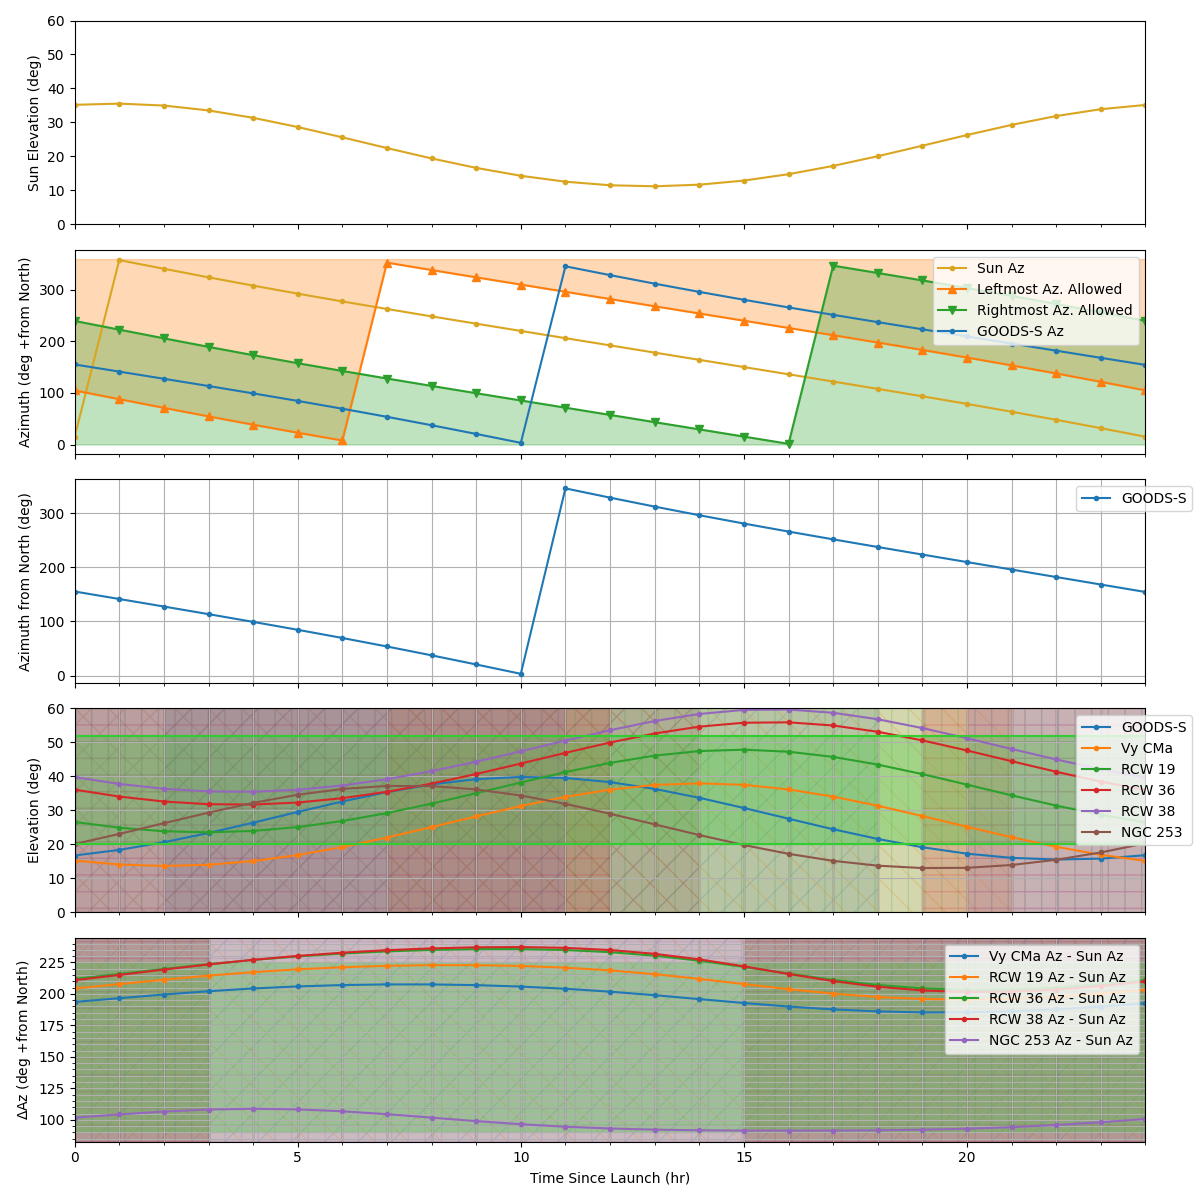

In [200]:
fig, ax = plt.subplots(figsize=(12,12), nrows=5, sharex=True)

ax[0].plot(t, sun_altaz.alt.deg, marker='.', color='goldenrod')
ax[0].set_ylim(0, 60)
ax[0].set_ylabel('Sun Elevation (deg)')

ax[1].plot(t, sun_altaz.az.deg, marker='.', color='goldenrod', label='Sun Az')
ax[1].plot(t, az_limleft(sun_altaz.az.deg), marker='^', color='C1', label='Leftmost Az. Allowed')
ax[1].fill_between(t.value, az_limleft(sun_altaz.az.deg), color='C1', y2=360, alpha=0.3)
ax[1].plot(t, az_limright(sun_altaz.az.deg), marker='v', color='C2', label='Rightmost Az. Allowed')
ax[1].fill_between(t.value, az_limright(sun_altaz.az.deg), color='C2', y2=0, alpha=0.3)
ax[1].plot(t, goods_s_altaz.az.deg, marker='.', label='GOODS-S Az')
ax[1].set_ylabel('Azimuth (deg +from North)')
ax[1].legend(loc='upper right')

plot_from_catalog_helper_t_vs_az(ax[2], 'GOODS-S', skycoord_override=goods_s)
ax[2].set_ylabel('Azimuth from North (deg)')
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper right')
ax[2].grid(which='both')
ax[2].set_xlim(t[0].value, t[-1].value)

hatch_idx = 0
plot_from_catalog_helper_t_vs_el(ax[3], 'GOODS-S', skycoord_override=goods_s)
plot_from_catalog_helper_t_vs_el(ax[3], 'Vy CMa')
rcw19, _, = plot_from_catalog_helper_t_vs_el(ax[3], 'RCW 19')
# rcw20, _ = plot_from_catalog_helper_t_vs_el(ax[3], 'RCW 20')
rcw36, _ = plot_from_catalog_helper_t_vs_el(ax[3], 'RCW 36')
rcw38, _ = plot_from_catalog_helper_t_vs_el(ax[3], 'RCW 38')
plot_from_catalog_helper_t_vs_el(ax[3], 'NGC 253')
# plot_from_catalog_helper_t_vs_el(ax[3], 'HH 47')
# plot_from_catalog_helper_t_vs_el(ax[3], 'TW Hydrae')
# plot_from_catalog_helper_t_vs_el(ax[3], '[MHL2007] G259.0453-01.5559 1')
# plot_from_catalog_helper_t_vs_el(ax[3], 'IRAS 08088-3554')
# plot_from_catalog_helper_t_vs_el(ax[3], 'CG 30')
# plot_from_catalog_helper_t_vs_el(ax[3], 'IRAS 08448-4343')
# rcw38, _ = plot_from_catalog_helper_t_vs_el(ax[3], 'M42')

ax[3].axhline(EL_MIN, color='limegreen')
ax[3].fill_between(t.value, EL_MIN, y2=EL_MAX, color='limegreen', alpha=0.3)
ax[3].axhline(EL_MAX, color='limegreen')
ax[3].set_ylim(0, 60)
ax[3].set_ylabel('Elevation (deg)')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper right')
ax[3].grid(which='both')
ax[3].set_xlim(t[0].value, t[-1].value)

hatch_idx = 0
# plot_from_catalog_helper_t_vs_delta_sun(ax[4], 'GOODS-S', skycoord_override=goods_s)
plot_from_catalog_helper_t_vs_delta_sun(ax[4], 'Vy CMa')
plot_from_catalog_helper_t_vs_delta_sun(ax[4], 'RCW 19')
plot_from_catalog_helper_t_vs_delta_sun(ax[4], 'RCW 36')
plot_from_catalog_helper_t_vs_delta_sun(ax[4], 'RCW 38')
plot_from_catalog_helper_t_vs_delta_sun(ax[4], 'NGC 253')
# plot_from_catalog_helper_t_vs_delta_sun(ax[4], 'HH 47')
# plot_from_catalog_helper_t_vs_delta_sun(ax[4], 'TW Hydrae')

ax[4].fill_between(t.value, DAZ_MIN, y2=DAZ_MAX, color='limegreen', alpha=0.3)
ax[4].set_ylabel('$\Delta$Az (deg +from North)')
ax[4].legend(loc='upper right')
ax[4].grid(which='both')
# ax[4].set_ylim(0, 360)
ax[4].set_xlabel('Time Since Launch (hr)')

plt.minorticks_on()
plt.tight_layout()

In [201]:
def altaz_to_radec_helper(alt, az):
    my_radec = SkyCoord(
        AltAz(
            alt=alt,
            az=az,
            obstime=times,
            location=mcmurdo
        )
    ).transform_to(ICRS)
    return my_radec

In [202]:
def plot_from_catalog_helper(ax, name):
    foo = SkyCoord.from_name(name)
    coord = SkyCoord(foo.ra, foo.dec, obstime=times, location=mcmurdo)
    ax.scatter(coord.ra, coord.dec, edgecolor='k', transform=ax.get_transform('icrs'), label=name)
    return foo

Plot a polygon on sky connecting the RA/Dec coordinates dictated by the el axis limits and the sun. One polygon per time coordinate

In [203]:
def allsky_query(hips, reload=False):
    fname = hips.replace('/', '_') + '.fits'
    if os.path.exists(fname) and reload:
        result = hips2fits.query(
            hips=hips,
            ra=0 * u.deg,
            dec=0 * u.deg,
            width=5000,
            height=2500,
            fov=360 * u.deg,
            projection='MOL',
            get_query_payload=False,
            format='fits',
        )
        result.writeto(fname, overwrite=True)

    hdu = fits.open(fname)
    h = hdu[0].header
    wcs = WCS(h, naxis=2) # reduce WCS dimensionality for polygon overplot
    d = hdu[0].data
    return wcs, h, d

In [204]:
# https://alasky.cds.unistra.fr/hips-image-services/hips2fits
wcs, h, d0 = allsky_query('CDS/P/IRIS/color', reload=False)
d0 = d0[2,:,:]

In [205]:
wcs, h, d1 = allsky_query('ESAVO/P/HERSCHEL/SPIRE-350', reload=False)

In [206]:
ds = [d1, d0]

Text(0.5, 0.98, 'Observing Time: 1.0 days')

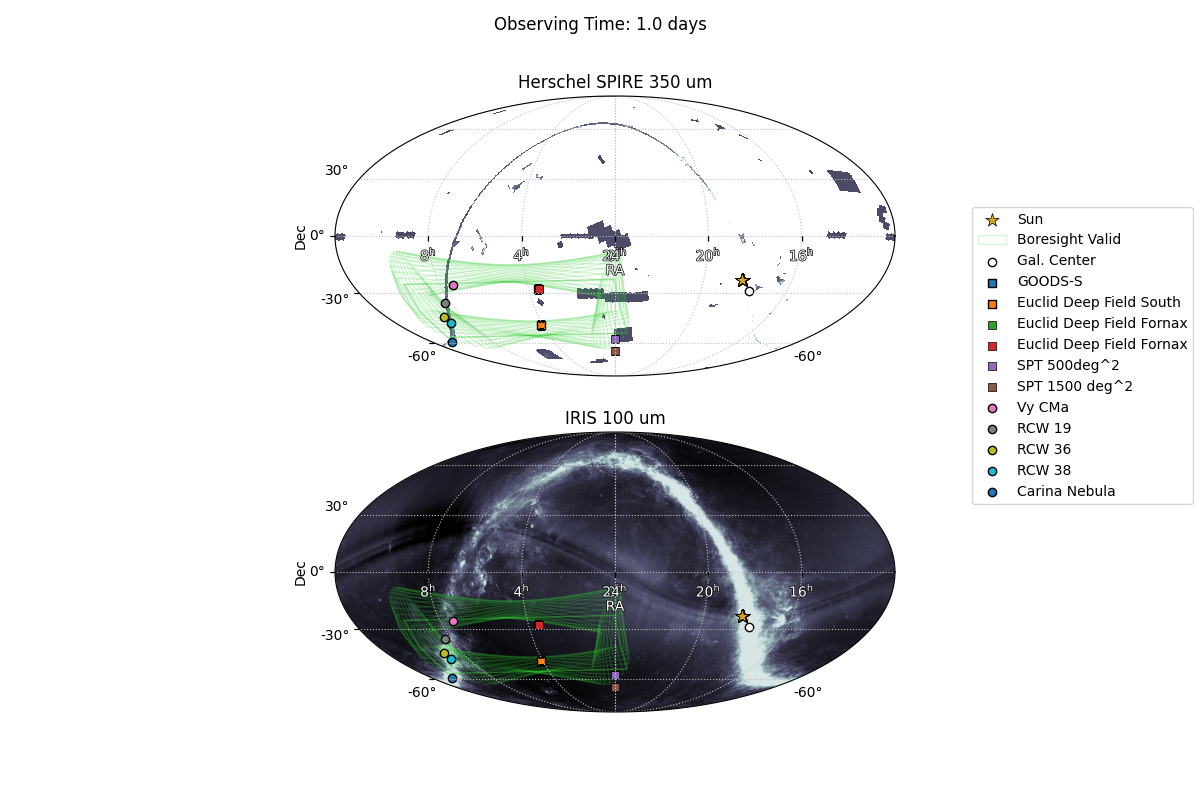

In [207]:
fig, axs = plt.subplots(figsize=(12,8), nrows=2, subplot_kw=dict(projection=wcs, frame_class=EllipticalFrame), sharex=True, sharey=True)
ax0, ax1 = axs

for j, ax in enumerate(axs):
    d = ds[j]

    lon = ax.coords[0]
    lat = ax.coords[1]
    lat.set_axislabel_position("c")

    path_effects=[patheffects.withStroke(linewidth=1, foreground='black')]
    lon.set_ticklabel(color='white', path_effects=path_effects)
    ax.grid(linestyle=':', color='silver')

    ax.imshow(d, vmin=np.nanmin(d), vmax=np.nanmean(d) + 2 * np.nanstd(d), cmap='bone')

    p = ax.scatter(sun.ra, sun.dec, s=100, marker='*', facecolor='goldenrod', edgecolor='k', linewidth=.5, transform=ax.get_transform('icrs'), label='Sun')

    limleftup_radec = altaz_to_radec_helper(EL_MAX * u.deg, az_limleft(sun_altaz.az.deg) * u.deg)
    limleftmid_radec = altaz_to_radec_helper((EL_MAX + EL_MIN)/2 * u.deg, az_limleft(sun_altaz.az.deg) * u.deg)
    limleftdown_radec = altaz_to_radec_helper(EL_MIN * u.deg, az_limleft(sun_altaz.az.deg) * u.deg)
    limrightup_radec = altaz_to_radec_helper(EL_MAX * u.deg, az_limright(sun_altaz.az.deg) * u.deg)
    limrightmid_radec = altaz_to_radec_helper((EL_MAX + EL_MIN)/2 * u.deg, az_limright(sun_altaz.az.deg) * u.deg)
    limrightdown_radec = altaz_to_radec_helper(EL_MIN * u.deg, az_limright(sun_altaz.az.deg) * u.deg)

    # coordinates of corners on plot
    # p = ax.scatter(limleftup_radec.ra, limleftup_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limleftmid_radec.ra, limleftmid_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limleftdown_radec.ra, limleftdown_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limrightup_radec.ra, limrightup_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limrightmid_radec.ra, limrightmid_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))
    # p = ax.scatter(limrightdown_radec.ra, limrightdown_radec.dec, marker='.', color='limegreen', alpha=0.4, transform=ax.get_transform('icrs'))

    rs = []
    for i in range(len(limleftup_radec)):
        verts = SkyCoord([
                limleftup_radec.ra[i],
                limleftmid_radec.ra[i],
                limleftdown_radec.ra[i],
                limrightdown_radec.ra[i],
                limrightmid_radec.ra[i],
                limrightup_radec.ra[i],
            ],
            [
                limleftup_radec.dec[i],
                limleftmid_radec.dec[i],
                limleftdown_radec.dec[i],
                limrightdown_radec.dec[i],
                limrightmid_radec.dec[i],
                limrightup_radec.dec[i],
            ],
            unit='deg',
            frame=ICRS
        )
        reg = PolygonSkyRegion(vertices=verts, visual=dict(fill=True, edgecolor='limegreen', facecolor=None))
        rs.append(reg)
    regions = Regions(rs)
    regions.write('myregions.reg', format='ds9', overwrite=True)

    px_regions = [r.to_pixel(wcs) for r in rs]
    for i, p in enumerate(px_regions):
        if i == 0:
            p.plot(ax=ax, edgecolor='limegreen', facecolor='none', alpha=max(1/len(times), 0.2), label='Boresight Valid')
        # p.plot(ax=ax, edgecolor='k', alpha=max(1/len(times), 0.01))
        p.plot(ax=ax, facecolor='none', edgecolor='limegreen', alpha=0.2)

    # some additional points of interest
    ax.scatter(gal_center.ra, gal_center.dec, facecolor='w', edgecolor='k', transform=ax.get_transform('icrs'), label='Gal. Center')
    ax.scatter(goods_s.ra, goods_s.dec, marker='s', edgecolor='k', transform=ax.get_transform('icrs'), label='GOODS-S')
    ax.scatter(edfs.ra, edfs.dec, marker='s', edgecolor='k', transform=ax.get_transform('icrs'), label='Euclid Deep Field South')
    ax.scatter(edff.ra, edff.dec, marker='s', linewidth=0.5, edgecolor='k', transform=ax.get_transform('icrs'), label='Euclid Deep Field Fornax')
    ax.scatter(edff.ra, edff.dec, marker='s', linewidth=0.5, edgecolor='k', transform=ax.get_transform('icrs'), label='Euclid Deep Field Fornax')
    ax.scatter(spt_summer.ra, spt_summer.dec, marker='s', linewidth=0.5, edgecolor='k', transform=ax.get_transform('icrs'), label='SPT 500deg^2')
    ax.scatter(spt_winter.ra, spt_winter.dec, marker='s', linewidth=0.5, edgecolor='k', transform=ax.get_transform('icrs'), label='SPT 1500 deg^2')

    plot_from_catalog_helper(ax, 'Vy CMa')
    rcw19 = plot_from_catalog_helper(ax, 'RCW 19')
    # rcw20 = plot_from_catalog_helper(ax, 'RCW 20')
    rcw36 = plot_from_catalog_helper(ax, 'RCW 36')
    rcw38 = plot_from_catalog_helper(ax, 'RCW 38')
    # plot_from_catalog_helper(ax, 'RCW 42')
    # plot_from_catalog_helper(ax, 'RCW 49')
    carina = plot_from_catalog_helper(ax, 'Carina Nebula')
    # plot_from_catalog_helper(ax, 'NGC 253')
    # plot_from_catalog_helper(ax, 'HH 47')
    # plot_from_catalog_helper(ax, 'TW Hydrae')
    # plot_from_catalog_helper(ax, 'NGC 3576')
    # plot_from_catalog_helper(ax, 'NGC 3603')
    # plot_from_catalog_helper(ax, 'Vela Molecular Ridge')
    # plot_from_catalog_helper(ax, 'Beta Gruis')
    # plot_from_catalog_helper(ax, '[MHL2007] G259.0453-01.5559 1') # Young Stellar Object Candidate
    # plot_from_catalog_helper(ax, 'NGC 2579')
    # plot_from_catalog_helper(ax, 'IRAS 08088-3554')
    # plot_from_catalog_helper(ax, 'CG 30')
    # plot_from_catalog_helper(ax, 'IRAS 08448-4343')

    # for hh in [120, 132, 133, 171, 188, 217, 219, 246]: # [46, 47, 72, 73, 74, 75,]
    #     plot_from_catalog_helper(ax, 'HH' + str(hh))

    ax.set_xlabel('RA', color='w', path_effects=path_effects)
    ax.set_ylabel('Dec')
    if j == 0:
        ax.legend(loc='upper right', ncol=1, bbox_transform=fig.transFigure, bbox_to_anchor=(1, 0.75))
    # fig.tight_layout()

ax0.set_title('Herschel SPIRE 350 um')
ax1.set_title('IRIS 100 um')
fig.suptitle(f'Observing Time: {(t[-1] - t[0]).to(u.day).value:.1f} days')

# fig.tight_layout()

astroplan constraints

In [208]:
from astroplan import Observer, FixedTarget, Constraint, AltitudeConstraint, SunSeparationConstraint
from astroplan import is_observable, is_always_observable, observability_table
from astroplan.plots import plot_sky, plot_parallactic, plot_altitude, plot_finder_image
from astroplan.target import get_skycoord

In [209]:
ldb = (-77.861 * u.deg, 167.061 * u.deg)

# ground track:
# Salter Test Flight Universal completed ~1 circuit in 11 days, 6 hr, 57 min. Average the longitudinal velocity.
# Really, ballons have a spatial velocity, so this constant lat assumption is an oversimplification.
dlon_dt = -(360 * u.deg / (11 * u.day + 6 * u.hr + 57 * u.min)).to(u.deg / u.hr)
lon = ldb[1] + dlon_dt * t
lon = wrap360(lon.to(u.deg).value) * u.deg
lat = 0 * u.deg + np.ones_like(lon.value) * ldb[0] + .2 * u.deg * np.sin(lon.to(u.rad) * 15)

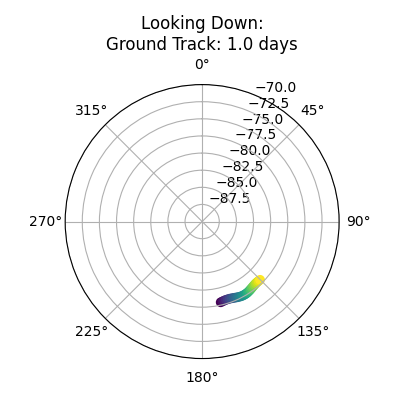

In [210]:
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(projection='polar'))

ax.scatter(lon.to(u.rad), lat, c=range(len(lon)))
ax.set_rmin(-90)
ax.set_rmax(-70)
# ax.set_rticks(np.arange(-90, -70, 5))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetamin(0)
ax.set_thetamax(360)
ax.grid(True)
ax.set_title(f'Looking Down:\nGround Track: {(t[-1] - t[0]).to(u.day).value:.1f} days')
fig.tight_layout()

In [211]:
class SunRelativeAzConstraint(Constraint):
    '''
    Constrain an asymmetrical sun-relative azimuth pointing of the boresight to
    target.
    These angles are the angles that the boresight must point away from the sun
    in order to maintain the instrument and electronics in the shade of the
    sunshade. As always, azimuth is measured +clockwise from the reference
    point, in this case the sun azimuth. The range is [0, 360] deg.
    '''
    def __init__(self, min=None, max=None):
        '''
        min : `~astropy.units.Quantity` or `None` (optional)
            Minimum acceptable azimuth angle between sun and boresight. `None`
            indicates no limit.
        max : `~astropy.units.Quantity` or `None` (optional)
            Maximum acceptable azimuth angle between sun and boresight. `None`
            indicates no limit.
        '''
        self.min = min if min is not None else 0*u.deg
        self.max = max if max is not None else 360*u.deg


    def compute_constraint(self, times, observer, targets):
        # targets = get_skycoord(targets)
        sun_body = get_body('sun', times, location=observer.location)
        sun = SkyCoord(ra=sun_body.ra, dec=sun_body.dec, obstime=times,
                       location=observer.location)
        sun_altaz = sun.transform_to('altaz')

        # Calculate separation between boresight and sun
        # Targets are automatically converted to SkyCoord objects
        # by __call__ before compute_constraint is called.

        try:
            n_targets = len(targets)
        except TypeError as e:
            targets = SkyCoord([targets,])
            n_targets = len(targets)
        try:
            n_times = len(times)
        except TypeError as e:
            # times = [times,]
            n_times = len(times)

        delta_az = np.atleast_2d(np.empty((n_targets, n_times)) * u.deg)
        for i, target in enumerate(targets):
            target_with_loc = SkyCoord(ra=target.ra, dec=target.dec, obstime=times, location=observer.location)
            target_altaz = target_with_loc.transform_to('altaz')
            delta_az[i,:] = wrap360(target_altaz.az.deg - sun_altaz.az.deg) * u.deg # time axis
        # print(n_targets, n_times, delta_az.shape, delta_az)

        if self.min is None and self.max is not None:
            mask = self.max >= delta_az
        elif self.max is None and self.min is not None:
            mask = self.min <= delta_az
        elif self.min is not None and self.max is not None:
            mask = ((self.min <= delta_az) &
                    (delta_az <= self.max))
        else:
            raise ValueError("No max and/or min specified in "
                             "SunRelativeAzConstraint.")
        return mask

In [212]:
tim = Observer(longitude=lon, latitude=lat, elevation=37000 * u.km, name="TIM")
targets = [
    FixedTarget(coord=goods_s, name='GOODS-S'),
    FixedTarget(coord=rcw19, name='RCW 19'),
    FixedTarget(coord=rcw36, name='RCW 36'),
    FixedTarget(coord=rcw38, name='RCW 38'),
    FixedTarget(coord=carina, name='eta Car')
]
constraints = [
    AltitudeConstraint(EL_MIN * u.deg, EL_MAX * u.deg),
    SunRelativeAzConstraint(min=90 * u.deg, max=225 * u.deg)
]

In [213]:
table = observability_table(constraints, tim, targets, times)

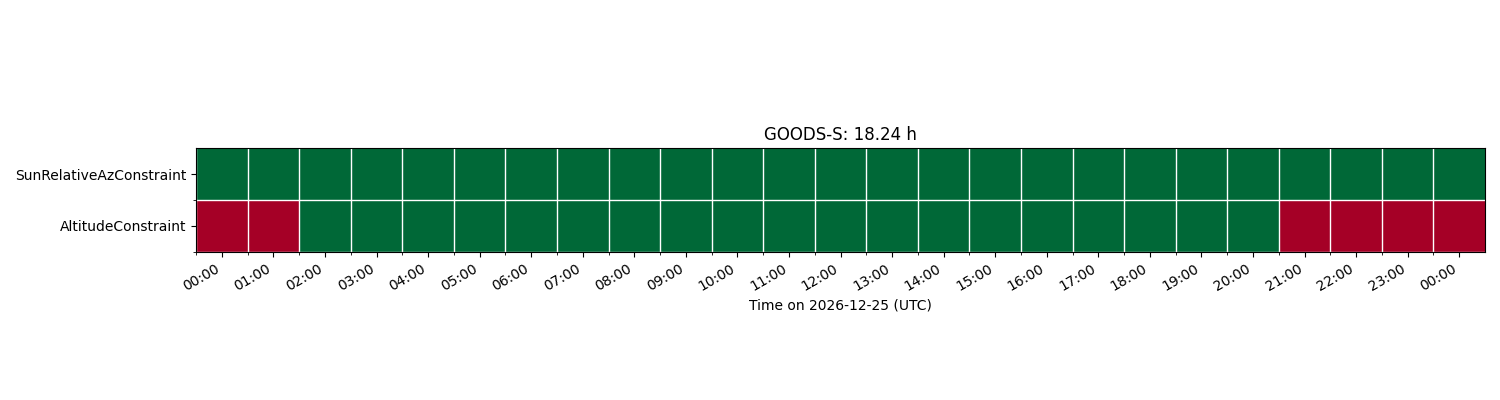

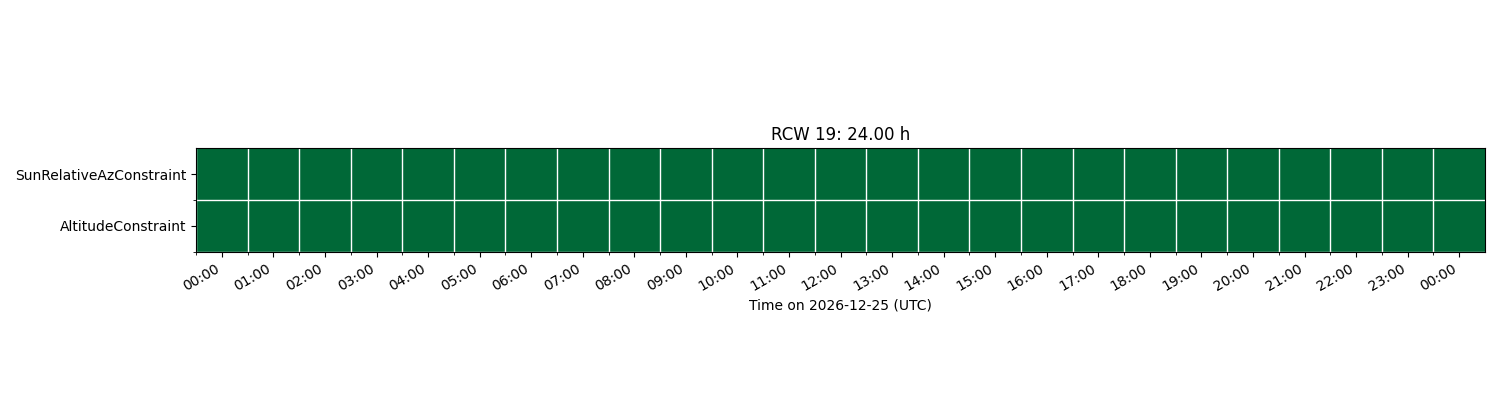

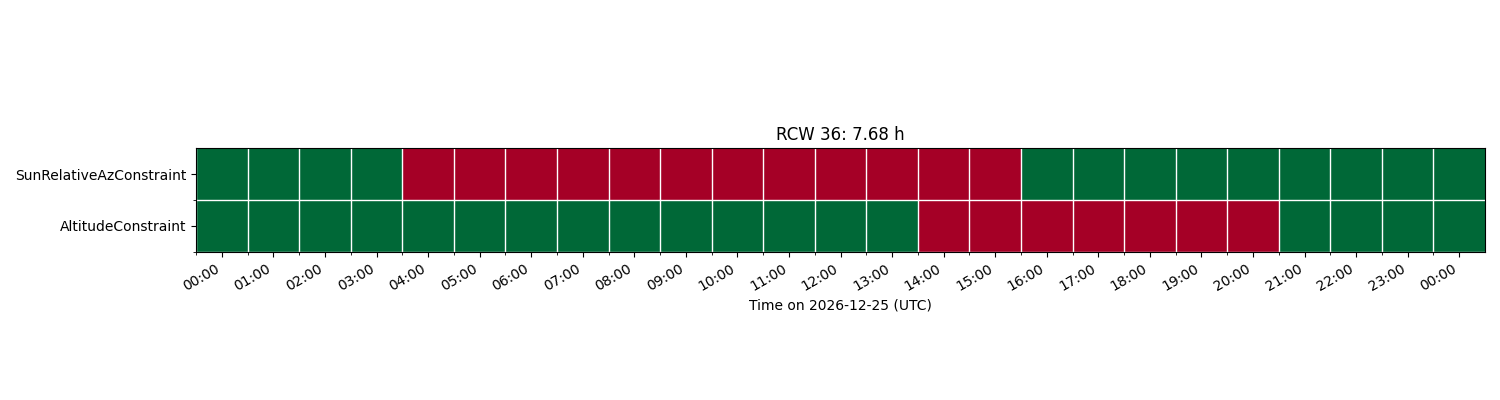

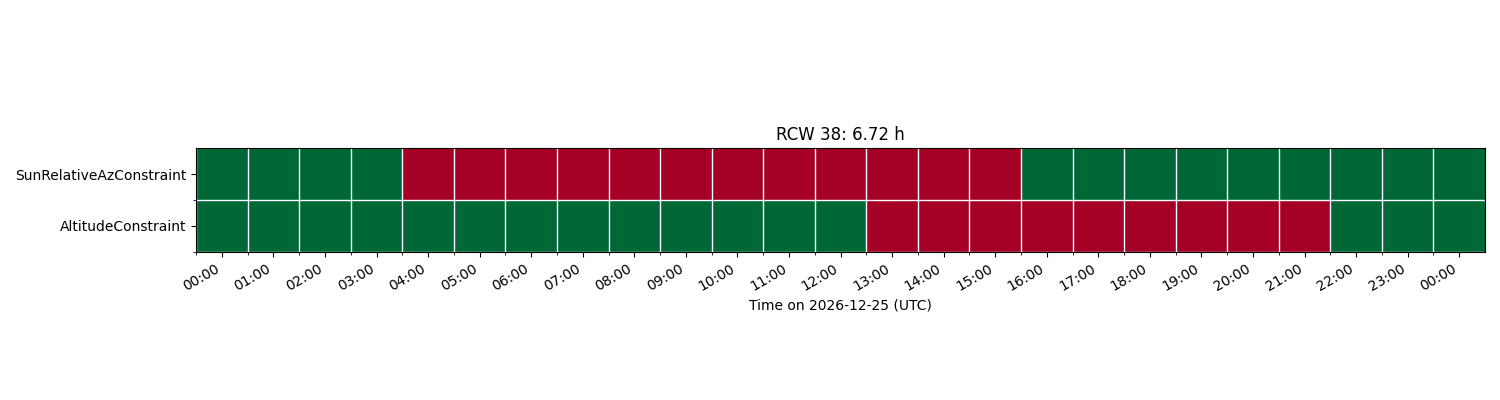

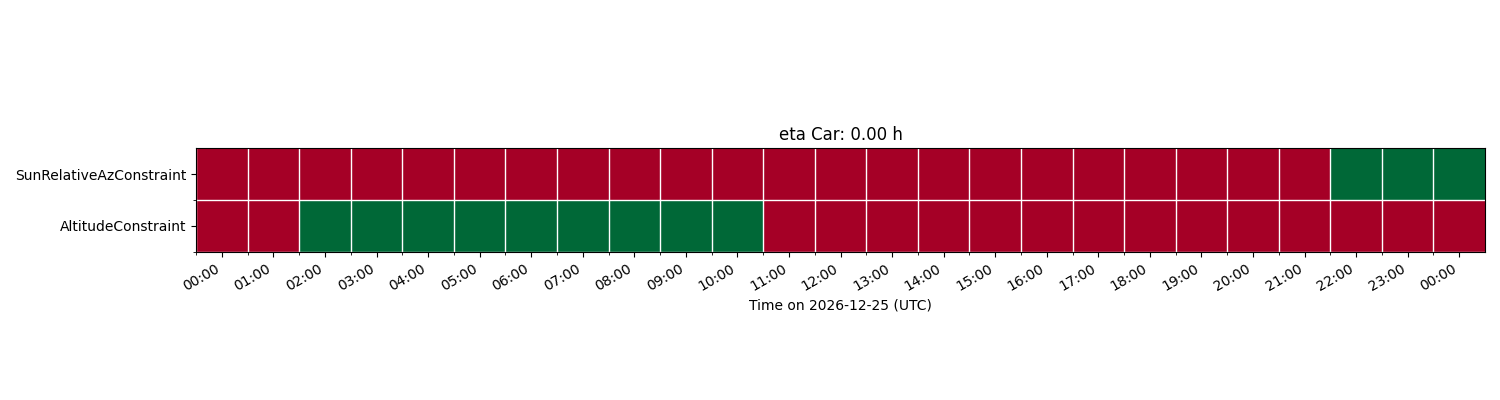

In [214]:
# https://astroplan.readthedocs.io/en/latest/tutorials/constraints.html
for j, target in enumerate(targets):
    observability_grid = np.zeros((len(constraints), len(times)))
    for i, constraint in enumerate(constraints):
        # Evaluate each constraint
        observability_grid[i, :] = constraint(tim, target, times=times, grid_times_targets=True)

    # Create plot showing observability of the target:
    extent = [-0.5, -0.5+len(times), -0.5, len(constraints) - 0.5]

    fig, ax = plt.subplots(figsize=(15,4))
    ax.imshow(observability_grid, extent=extent, cmap='RdYlGn', vmin=0, vmax=1, origin='lower')

    ax.set_yticks(range(0, len(constraints)))
    ax.set_yticklabels([c.__class__.__name__ for c in constraints])

    ax.set_xticks(range(len(times)))
    ax.set_xticklabels([t.datetime.strftime("%H:%M") for t in times])

    ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
    ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
    ax.tick_params(axis='x', which='minor', bottom='off')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    ax.tick_params(axis='y', which='minor', left='off')
    ax.set_xlabel('Time on {0} (UTC)'.format(times[0].datetime.date()))
    fig.subplots_adjust(left=0.25, right=0.9, top=0.9, bottom=0.1)
    ax.set_title(f'{target.name}: {table["fraction of time observable"][j] * (times[-1] - times[0]).to(u.hr):.2f}')
    fig.tight_layout()
    plt.show()

    # fig, ax = plt.subplots(figsize=(12,4))
    # plot_altitude(target, tim, times, ax=ax)
    # ax.axhline(EL_MIN)
    # ax.axhline(EL_MAX)
    # ax.set_title(target.name)
    # plt.show()

/home/evanmayer/miniconda3/envs/astr/lib/python3.10/site-packages/astroplan/plots/time_dependent.py:399: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot_date(time.plot_date, masked_altitude, label=target_name, **style_kwargs)
/home/evanmayer/miniconda3/envs/astr/lib/python3.10/site-packages/astroplan/plots/time_dependent.py:399: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot_date(time.plot_date, masked_altitude, label=target_name, **style_kwargs)
/home/evanmayer/miniconda3/envs/astr/lib/python3.10/site-packages/astroplan/plots/time_dependent.py:399: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot_date(

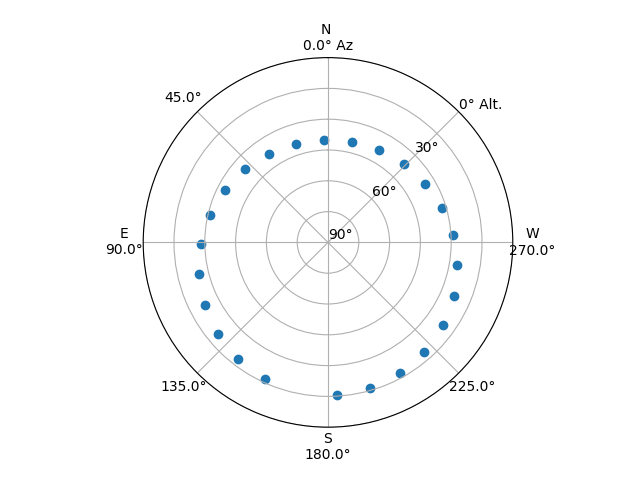

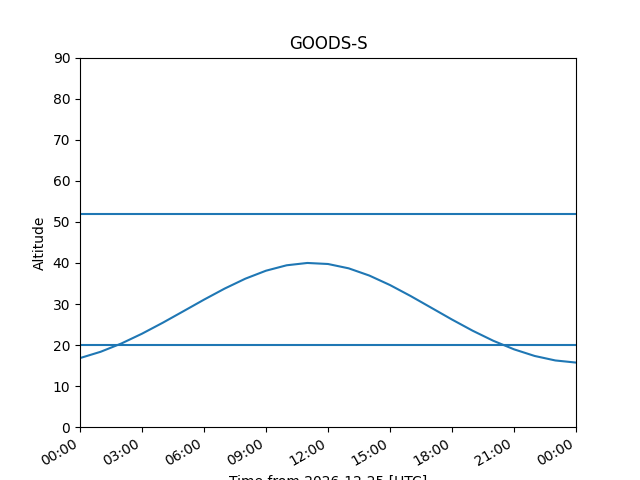

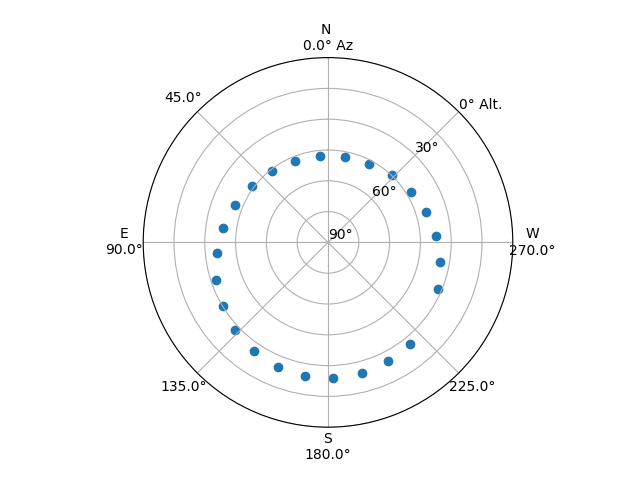

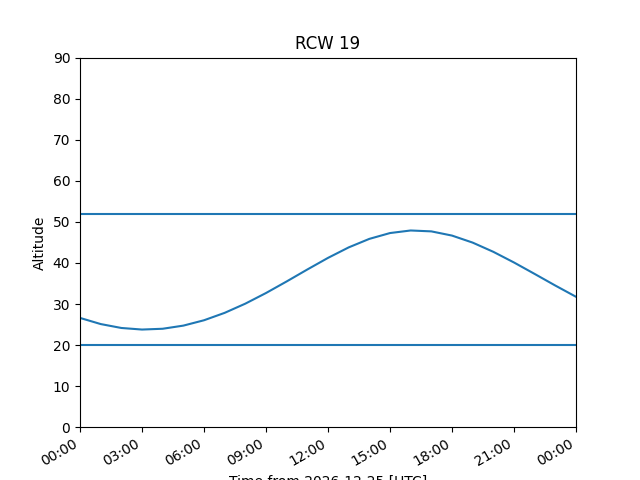

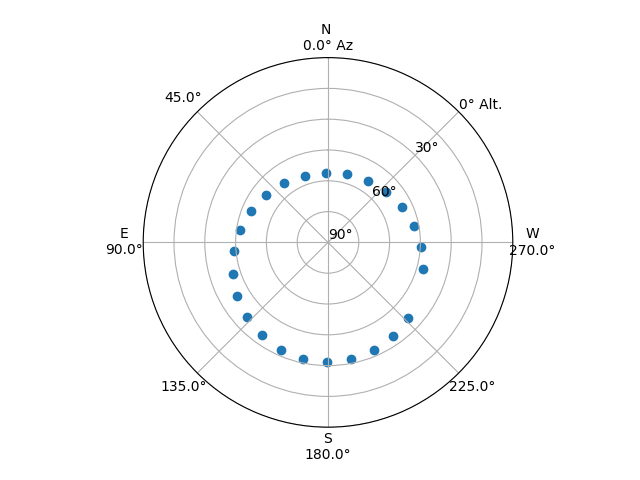

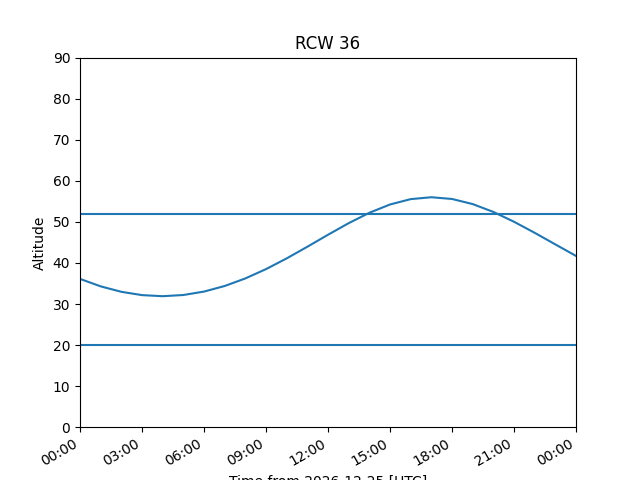

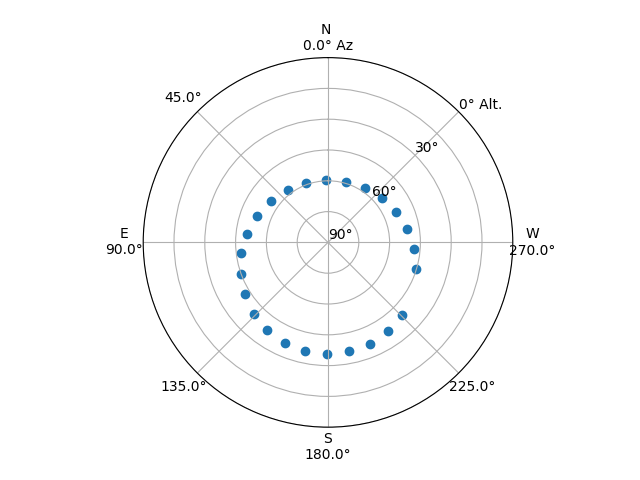

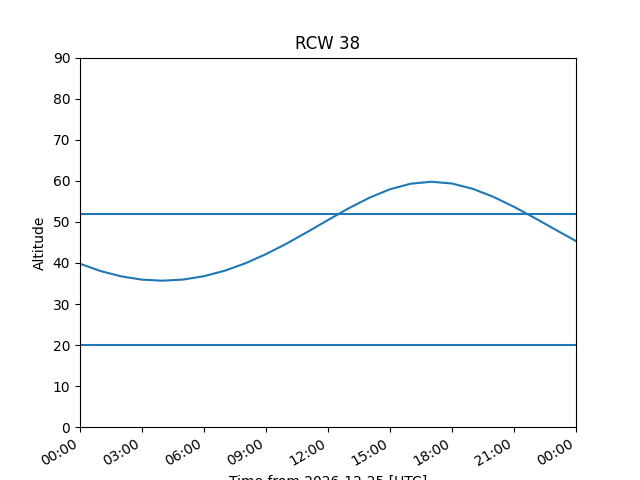

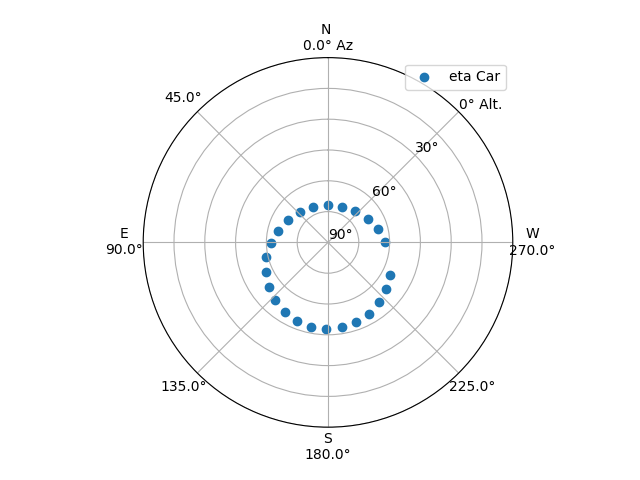

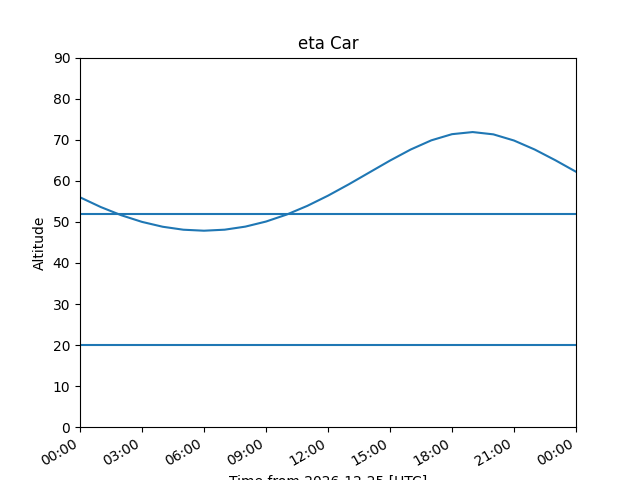

In [215]:
for target in targets:
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    plot_sky(target, tim, times, ax=ax)
    fig, ax1 = plt.subplots()
    plot_altitude(target, tim, times, ax=ax1)
    ax1.axhline(EL_MIN)
    ax1.axhline(EL_MAX)
    ax1.set_title(target.name)

ax.legend()